In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Examples

> Various examples of CausalNLP on semi-simulated or real datasets.

In [ ]:
from causalnlp.causalinference import CausalInferenceModel
from causalnlp.autocoder import Autocoder

## What is the causal impact of a positive review on product views?

We use a semi-simulated dataset generated from [this repo](https://github.com/rpryzant/causal-text), which is available in the `sample_data` folder. The reviews and product types are real, while the outcomes (e.g., 1=product clicked, 0=not clicked) are simulated.

In [ ]:
#notest
import pandas as pd
df = pd.read_csv('sample_data/music_seed50.tsv', sep='\t', error_bad_lines=False)

In [ ]:
#notest
df.head()

,index,id,rating,product,text,summary,price,T_true,C_true,Y_sim,negative,positive,T_ac
0,7,0001388703,1.0,mp3 music,buy the cd. do not buy the mp3 album. downlo...,Buy the CD. Do not buy the MP3.,13.01,0,0,0,0.548733,0.451267,0
1,8,0001388703,5.0,mp3 music,takes me back to my childhood!,Love it!,13.01,1,0,0,0.008373,0.991627,1
2,12,0001388703,5.0,audio cd,the passion and ingenuity of green's music is ...,No one like Keith Green,13.01,1,1,1,0.043761,0.956239,1
3,13,0001388703,5.0,mp3 music,keith's music is a timeless message. since hi...,Never Gets Old,13.01,1,0,1,0.038876,0.961124,1
4,15,0001377647,5.0,audio cd,i have fallen in love with john michael talbot...,Talbot a masterpiece,18.99,1,1,1,0.019828,0.980172,1


`Y_sim` is the simulated outcome indicating whether or not the product was clicked.  `C_true` is a categorical variable, where 1 is an audio CD and and 0 is something else (e.g., MP3).  In this dataset, outcomes were simulated such that `C_true` is a counfounding variable for this problem.

The treatment is whether or not the review is positive, which affects `Y_sim`.  Let's pretend we don't have a rating and need to infer this from text using the `Autocoder`. This can be done with:
```python
ac = Autocoder()
df = ac.code_sentiment(df['text'].values, df, batch_size=16, binarize=True)
df['T_ac'] = df['positive']
 ```
We've already created this as the `T_ac` column (along with the `positive` and `negative` columns), so invoking the above is not needed. Note that `T_ac` is an imperfect approximation of `T_true`. In CausalNLP, we can include the raw text as covariates to improve our estimates.

Let's fit the causal inference model.  We will adjust for both `C_true` and the raw text of the review to minimize bias from confounding. CausalNLP supports the following metalearners: S-Learner, T-Learner, X-Learner, and R-Learner. See [this paper](https://arxiv.org/abs/1706.03461) for more information on these. We will use the T-Learner as the metalearner here. By default, T-Learners use LightGBM classifiers with 31 leaves.  Let's increase the number of leaves to 500. In practice, you can supply a learner with hyperparameters that you've tuned beforehand to accurately predict the outcome.

In [ ]:
#notest
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
cm = CausalInferenceModel(df, metalearner_type='t-learner',
                    learner=LGBMClassifier(num_leaves=500),
                    treatment_col='T_ac', 
                    outcome_col='Y_sim', 
                    text_col='text',
                    include_cols=['C_true'])
cm.fit()

outcome column (categorical): Y_sim
treatment column: T_ac
numerical/categorical covariates: ['C_true']
text covariate: text
preprocess time:  1.112027883529663  sec
start fitting causal inference model
time to fit causal inference model:  10.733158826828003  sec


### Average Treatment Effect (ATE)
We can calculate the overall average treatment effect (ATE) as follows:

In [ ]:
#notest
cm.estimate_ate()

{'ate': 0.1309311542209525}

Since this is a simulated dataset, we can estimate the ground truth ATE: `0.1479` (14.79 pp change in outcome).

In [ ]:
#notest
from collections import defaultdict
import numpy as np
def ATE_adjusted(C, T, Y):
    x = defaultdict(list)
    for c, t, y in zip(C, T, Y):
        x[c, t].append(y)

    C0_ATE = np.mean(x[0,1]) - np.mean(x[0,0])
    C1_ATE =  np.mean(x[1,1]) - np.mean(x[1,0])
    return np.mean([C0_ATE, C1_ATE])
print(ATE_adjusted(df.C_true, df.T_true, df.Y_sim))

0.14785542719890196


### Conditional Average Treatment Effect (CATE)

We can also calculate the conditional average treatment effects (CATE). For instance, here is the treatment effect for those reviews that mention the word ``toddler.''

In [ ]:
#notest
series = df['text']
cm.estimate_ate(df['text'].str.contains('toddler'))

{'ate': 0.15559234254638685}

### Individualized Treatment Effect (ITE)

We can easily predict the treatment effect for new or existing observations on a per-unit basis.  We just need to make sure the DataFrame supplied as input to `CausalInferenceModel.predict` contains the right columns. This can easily be checked with `CausalInferenceModel.get_required_columns`:

In [ ]:
#notest
cm.get_required_columns()

['T_ac', 'C_true', 'text']

In [ ]:
#notest
test_df = pd.DataFrame({
    'T_ac' : [1],
    'C_true' : [1],
    'text' : ['I love the music of Zamfir and his pan flute.']
      })

In [ ]:
#notest
cm.predict(test_df)

array([[0.40062776]])

### Model Interpetability

We can use the `interpret` method to identify the attributes most predictive of individualized treatment effects across observations.  Features begnning with `v_` are word (or vocabulary) features.  We see that words like "music", "cd", and "love" in addition to the categorical attribute `C_true` (the known confounder which is 1 for audio CDs) are most predictive of *individualized* causal effects.

In [ ]:
#notest
cm.interpret(plot=False, method='feature_importance')[1][:10]

v_music    0.079042
v_cd       0.066838
v_album    0.055168
v_like     0.040784
v_love     0.040635
C_true     0.039949
v_just     0.035671
v_song     0.035362
v_great    0.029918
v_heard    0.028373
dtype: float64

  0%|          | 0/1 [00:00<?, ?it/s]

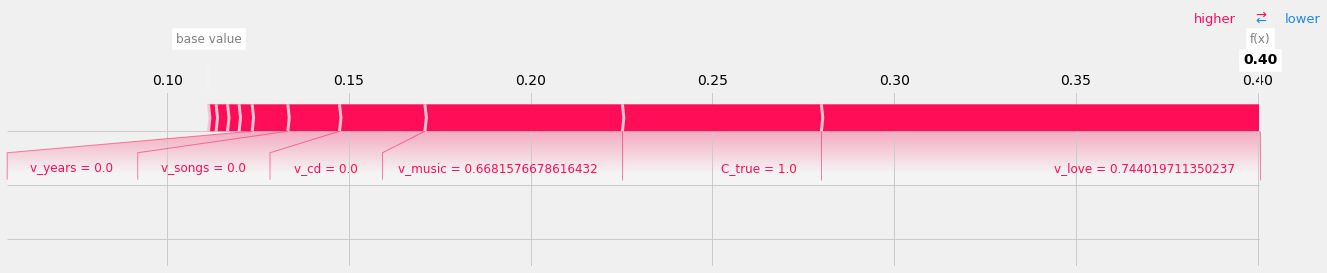

In [ ]:
#notest
cm.explain(test_df, row_num=0)

 ## What is the causal impact of a foreclosure or short sale on the sale price of homes greater than 2000 square feet?
 
 > Text is Optional in CausalNLP
 
 Despite the "NLP" in the name, **CausalNLP** can be used for causal analyses on traditional tabular datasets with no text fields.
 
 Here, we will estimate the causal effect of an abnormal sale (e.g., short sale, foreclosure), on the sale price of homes greater than 2000 square feet.  The dataset is available on Kaggle [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/).

In [ ]:

# prepare test
import pandas as pd
df = pd.read_csv('sample_data/houses.csv')
fn = lambda x: 1 if x == 'Abnorml' else 0
df['treatment'] = df['SaleCondition'].apply(fn)

# estimate effect of foreclosures and short sales
# on sale price of homes > 2000 sq.
from causalnlp.causalinference import CausalInferenceModel
cm = CausalInferenceModel(df, metalearner_type='t-learner',
                   treatment_col='treatment', 
                   outcome_col='SalePrice',
                   ignore_cols=['Id', 'SaleCondition'])
cm.fit()
cm.estimate_ate(df['GrLivArea']>2000)

outcome column (numerical): SalePrice
treatment column: treatment
numerical/categorical covariates: ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 

{'ate': -36015.017991264394}

In [ ]:
cm.interpret(plot=False)[1][:10]

OverallQual     0.163584
GrLivArea       0.159544
ExterQual_Ex    0.140019
BsmtFinSF1      0.051894
GarageArea      0.051558
GarageYrBlt     0.047060
YearRemodAdd    0.035756
LotArea         0.023736
TotalBsmtSF     0.022705
WoodDeckSF      0.022463
dtype: float64

The T-Learner predicts a discount of $36K with quality and square footage having the most impact on the size of the discount.

We can predict causal impacts on a per-unit basis:

In [ ]:
test_df = cm.df.iloc[[0]]
cm.predict(test_df)

array([[14503.81721707]])

  0%|          | 0/1 [00:00<?, ?it/s]

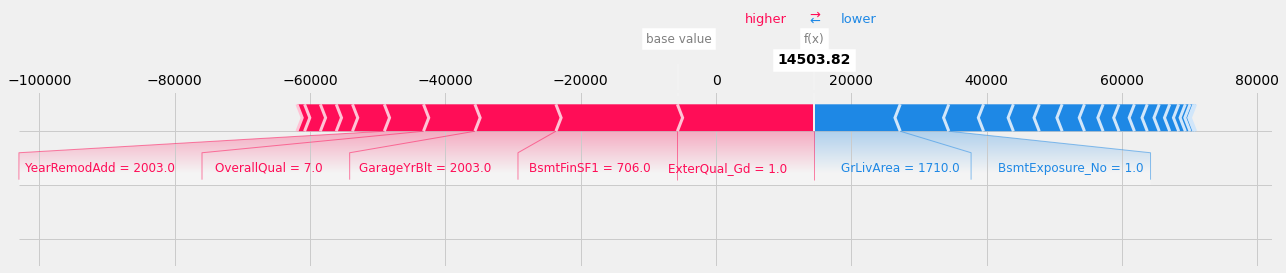

In [ ]:
cm.explain(cm.df.iloc[[0]])